# Wordart example notebook
Prototyping text source lookup via various API's and word cloud rendering with added features. Will eventually be a webapp most likely. 

* Classes (see bottom for docs)
  * words_api.py - `NYTReader` - API reader and search/plot/pos functions
  * words_api.py - `TwitterReader` - API reader and search/plot/pos functions
  * words_visualization.py - `WordArt` - Image handling and wordlcouds
    
    
* Resources
  * [WordCloud](https://github.com/amueller/word_cloud) package
  * Colormap [lookup](https://matplotlib.org/examples/color/colormaps_reference.html)

## Imports

In [6]:
import requests
import json
import numpy as np
import math
import time
import pandas as pd
import nltk
from matplotlib import pyplot as plt
import os

from IPython.display import display

import matplotlib
matplotlib.rcParams.update({'font.size': 14})

from PIL import Image, ImageOps, ImageEnhance
from wordcloud import WordCloud, STOPWORDS

from requests_oauthlib import OAuth1

In [7]:
%run words_api.py
%run words_visualization.py

## Pull in secret keys

In [8]:
private_data = json.loads(open('private_data.json').read())
nyt_key = private_data['nytimes-api-key']
twitter_auth_dict = private_data['twitter-auth']

# New York Times API

## Fetch some data

In [9]:
# sf bay
reader_sf = NYTReader(nyt_key)
reader_sf.get_search_term(search='headline:("San Francisco", "Oakland", "Silicon Valley")', 
                             begin_date='20010101',
                             article_limit=200, 
                             verbose=True)

Request failed, only got 70 docs
Got 70 docs, from 2003-10-07T00:00:00Z to 2017-10-12T20:27:23+0000


## Methods

### Testing words from different types of sources
This example only prints proper nouns. Base class dict `WordsAPI.pos` contains different types of parts of speech to use

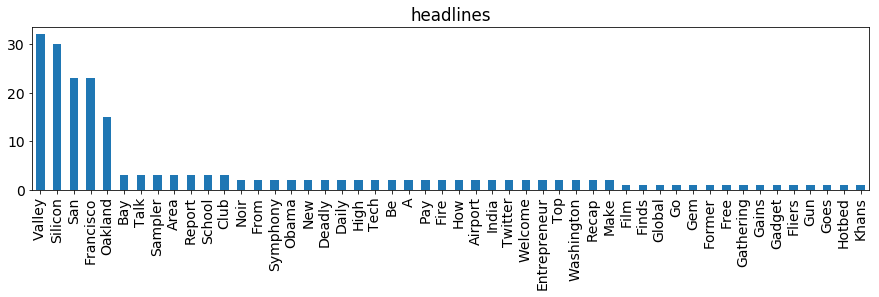

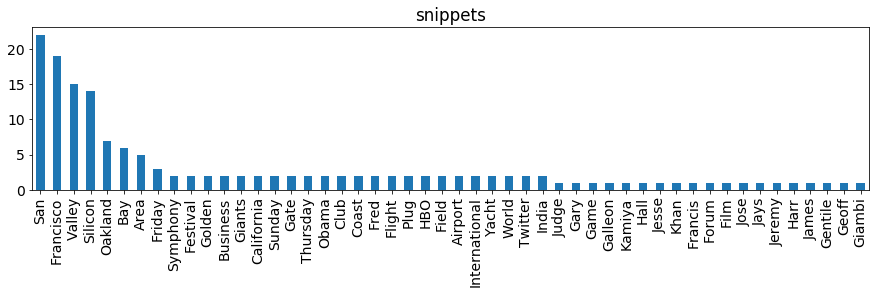

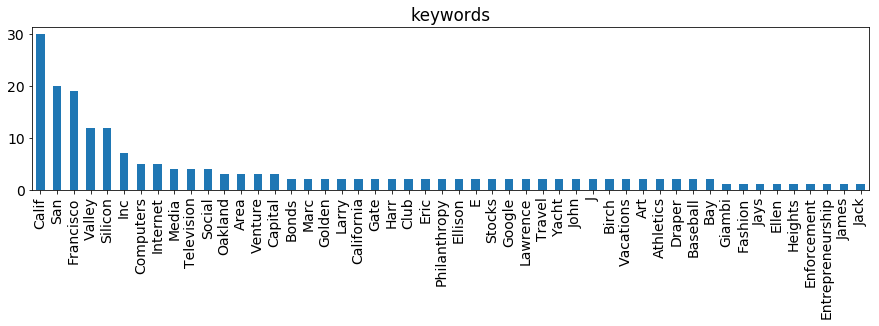

In [10]:
for source in reader_sf.text_sources.keys():
    reader_sf.plot_top_words(df=reader_sf.df_from_text([source]), n=50, title=source, 
                      pos_list=reader_sf.pos['include'], exclude=False, print_tuple=False)

### Searching and printing

In [11]:
reader_sf.get_single_entity(1)

HEADLINE: Living In Bernal Heights, San Francisco
SNIPPET: Property values have rapidly appreciated in this San Francisco neighborhood, but there’s still a communal vibe — and a coyote.
KEYWORD: San Francisco (Calif) | Real Estate and Housing (Residential) | Bernal Heights (San Francisco, Calif)
DATETIME: 2016-12-10T10:00:34+0000



In [12]:
reader_sf.search('Internet')

HEADLINE: On Internet TV, Silicon Valley Displays Its Whimsical Side
SNIPPET: Jesse Draper, host of "The Valley Girl Show," a freewheeling interview program, says her goal is to build a brand by "portraying serious business people as fun."
KEYWORD: E-Commerce | Computers and the Internet | Draper, Timothy C | Television | Silicon Valley (Calif) | Draper, Jesse
DATETIME: 2011-12-25T18:32:04Z

HEADLINE: Daily Report: From Lemonade Stand to Twitter’s I.P.O., a 10-Year-Old’s Journey to Silicon Valley
SNIPPET: Vivienne Harr became an Internet sensation for a lemonade stand she started to end child slavery. Now, she has a crowdfunding app that’s funded by Twitter and Google luminaries. Hers is a story of the power of networking in the social media age.
KEYWORD: Dorsey, Jack | Harr, Eric | Harr, Vivienne | Stone, Biz | Tan, Chade-Meng | Make a Stand Inc | Mobile Applications | Philanthropy | Social Media
DATETIME: 2014-10-08T08:09:42Z

HEADLINE: On Internet TV, Silicon Valley Displays Its Whi

### Build word list
This method will return a list of words of the specified parts of speech

In [13]:
text_words = reader_sf.get_words(source_list=['headlines', 'snippets'], pos_list=None, exclude=False)

print('%d total words, %d unique words' % (len(text_words), len(set(text_words))))

2300 total words, 1139 unique words


## Make wordcloud image

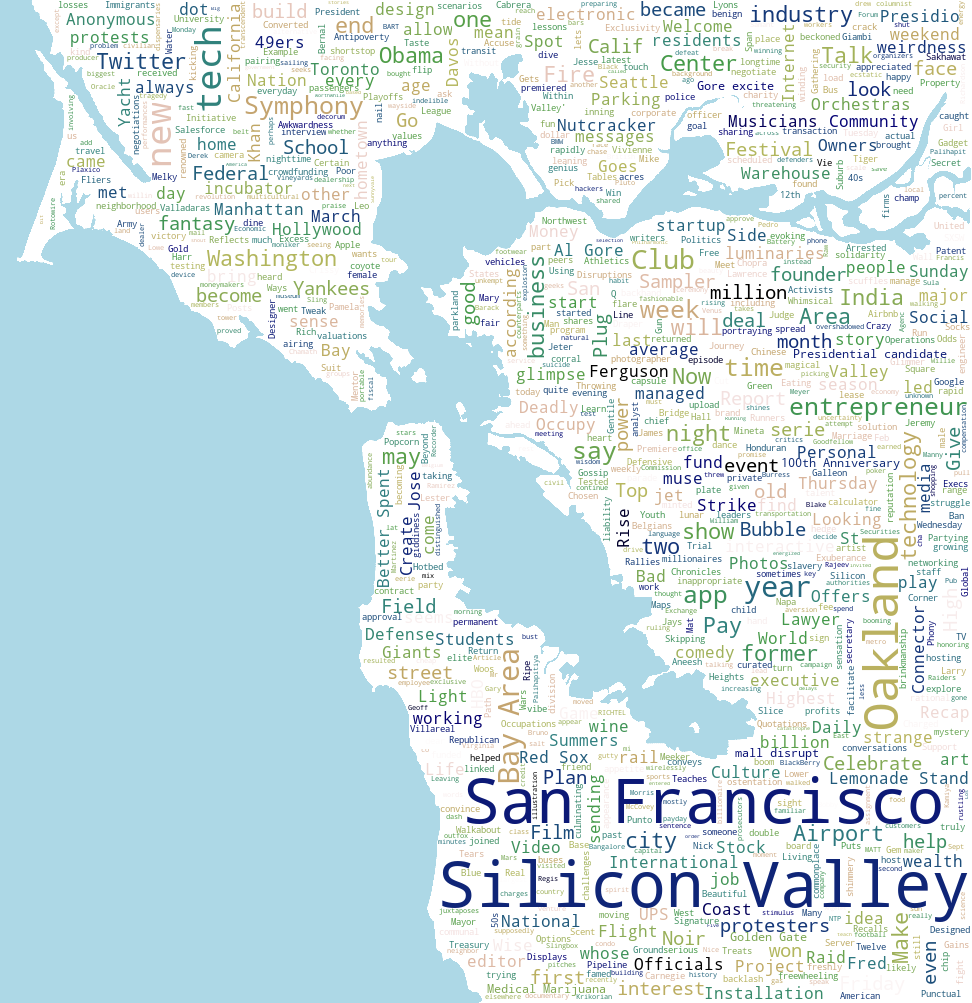

In [14]:
# get list of text sources
text_list = reader_sf.build_list_from_sources(source_list=['headlines','snippets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/Location_Map_San_Francisco_Bay_Area_edited.gif')

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/sf_bay.png", 
               colormap='gist_earth', background='lightblue')

# Twitter

In [15]:
%run words_visualization.py
%run words_api.py

## Define authorization

In [16]:
auth = OAuth1(client_key=twitter_auth_dict['client_key'],
                client_secret=twitter_auth_dict['client_secret'],
                resource_owner_key=twitter_auth_dict['resource_owner_key'],
                resource_owner_secret=twitter_auth_dict['resource_owner_secret'])

## Get tweets

### By search term

In [17]:
reader_twitter = TwitterReader(auth)
reader_twitter.get_search_term(search='Oakland', tweet_limit=200, verbose=True, recent=True)

Got 200 tweets from 2018-05-27 20:00:13 to 2018-05-27 20:17:18, allowance now 167 requests


### By geolocation
Note this doesn't always work reliably, consider using the `get_recent_tweets()` method instead

In [18]:
reader_twitter.get_search_term(geo='37.817941,-122.352714,20mi', tweet_limit=200, verbose=True)

Got 200 tweets from 2018-05-27 20:16:40 to 2018-05-27 20:17:20, allowance now 165 requests


### Filter realtime tweets by location
Note these take a while to load so limits should be set lower

In [19]:
reader_twitter_rt = TwitterReader(auth)
reader_twitter_rt.get_recent_tweets(location_box='-122.75,36.8,-121.75,37.8', tweet_limit=10, verbose=True)

Got 10 tweets from 2018-05-27 20:17:46 to 2018-05-27 20:17:59, allowance now 165 requests


## Methods

### Testing words from different types of sources
This example only prints proper nouns. Base class dict `WordsAPI.pos` contains different types of parts of speech to use

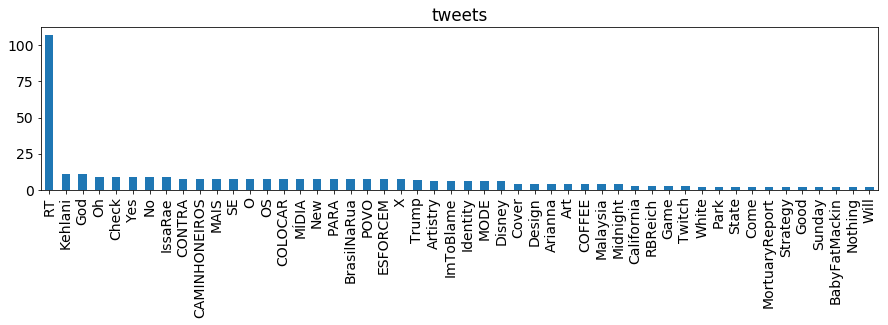

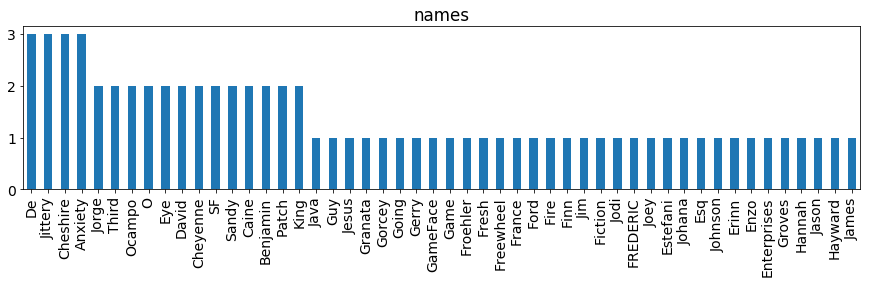

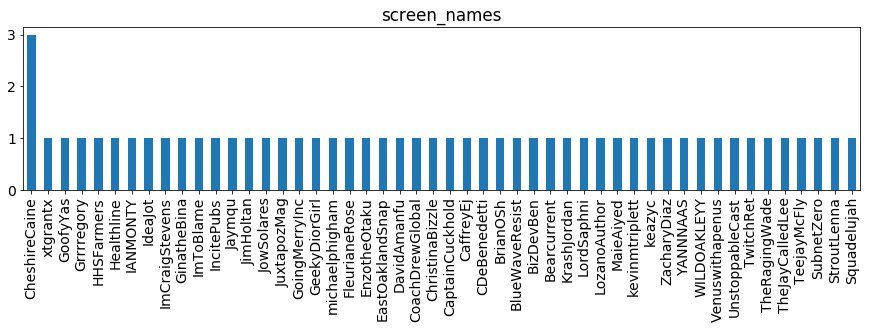

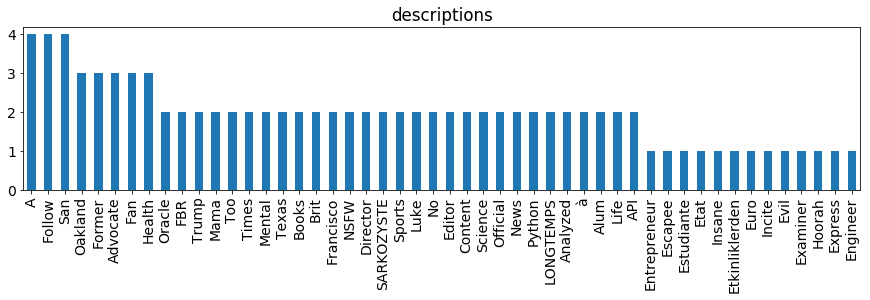

In [20]:
for source in reader_twitter.text_sources.keys():
    reader_twitter.plot_top_words(df=reader_twitter.df_from_text([source]), n=50, title=source, 
                      pos_list=reader_twitter.pos['include'], exclude=False, print_tuple=False)

### Searching and printing

In [21]:
reader_twitter.get_single_entity(1)

TWEET: RT @WatchVRV: one of these things... doesn't belong https://t.co/6MfwoeGm54
NAME: Enzo Perez
SCREEN_NAME: EnzotheOtaku
DESCRIPTION: Insane Asylum Escapee, Fan of animation(Anime/Cartoons/Video Games), I make vids about anime, you know... the usual.
DATETIME: 2018-05-27 20:17:20



In [22]:
reader_twitter.search('Warriors')

TWEET: Happy Birthday @mortenofficial 🥂 + big ups to the #Warriors on their win last night! #TempleSF #TempleTen https://t.co/vF275zosDN
NAME: Temple SF
SCREEN_NAME: Temple_SF
DESCRIPTION: Temple Nightclub is host to a world-class nightlife experience in an amazing audio-visual environment. Tickets ⬇️
DATETIME: 2018-05-27 20:17:14

TWEET: @khloekardashian Did you say any of this to Tristan “3rd Trimester” Thompson 🤷🏿‍♀️
NAME: SlaywTheBeyhive
SCREEN_NAME: complicted_leo
DESCRIPTION: Other handle #Slaywthebeyhive hacked. Oakland girl living my dream. #Warriors #DubNation #Beyhive #QueenBey
DATETIME: 2018-05-27 20:16:54



### Build word list
This method will return a list of words of the specified parts of speech

In [23]:
text_words = reader_twitter.get_words(source_list=['tweets'], pos_list=None, exclude=False)

print('%d total words, %d unique words' % (len(text_words), len(set(text_words))))

3134 total words, 1195 unique words


## Make wordcloud

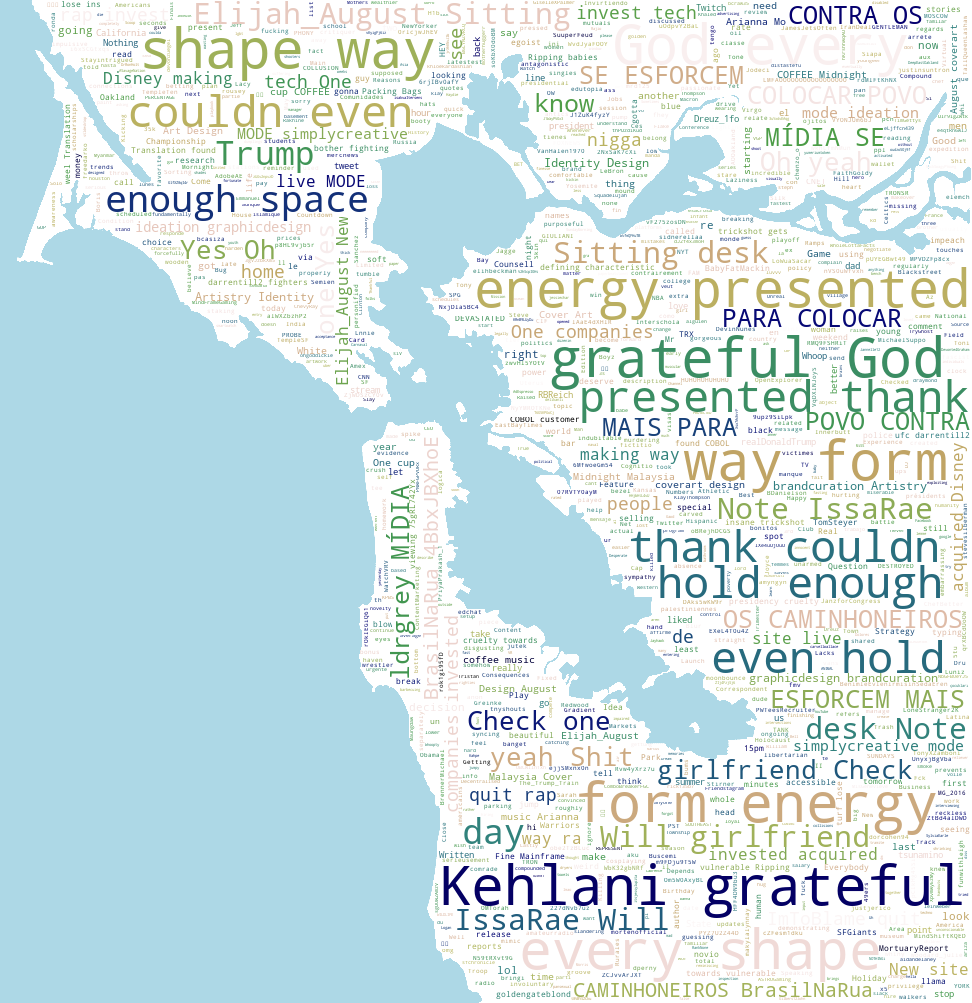

In [24]:
# get list of text sources
text_list = reader_twitter.build_list_from_sources(source_list=['tweets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/Location_Map_San_Francisco_Bay_Area_edited.gif')

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/sf_bay_twitter.png", 
               colormap='gist_earth', background='lightblue',
               additional_stopwords=['https', 'co', 'amp', 'RT'], 
               reset_stopwords=False)


# More wordclouds

Got 210 docs, from 1860-01-23T00:03:58Z to 2015-11-12T01:43:28Z


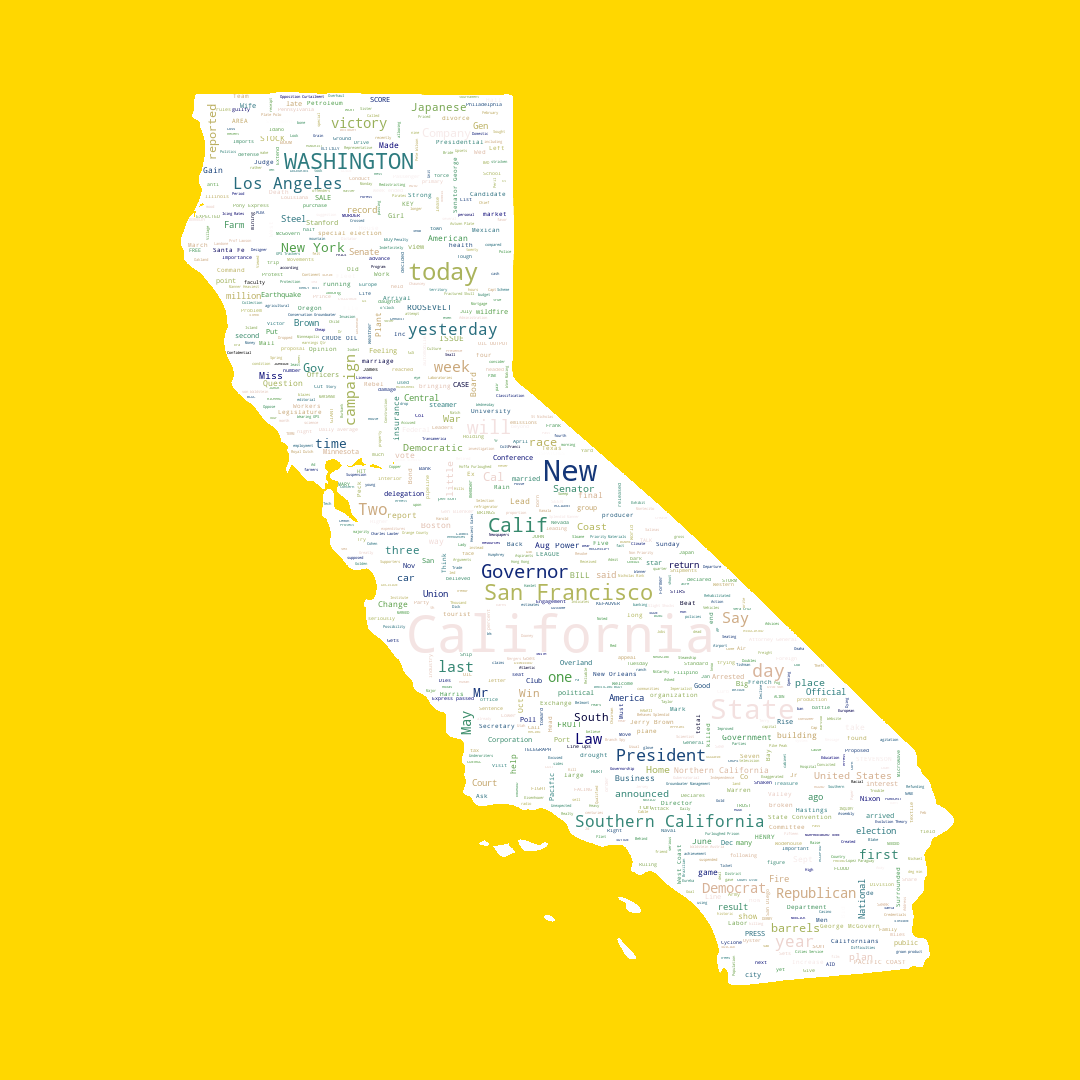

In [25]:
# california
reader_ca = NYTReader(nyt_key)
reader_ca.get_search_term(search='headline:("California")', 
                             article_limit=200,
                             verbose=True)

# get list of text sources
text_list = reader_ca.build_list_from_sources(source_list=['headlines','snippets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/kalifornien_schwarz.png', transparency=True)

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/ca.png", 
               colormap='gist_earth', background='gold')

Got 210 docs, from 2001-06-26T00:00:00Z to 2017-09-09T21:36:13+0000


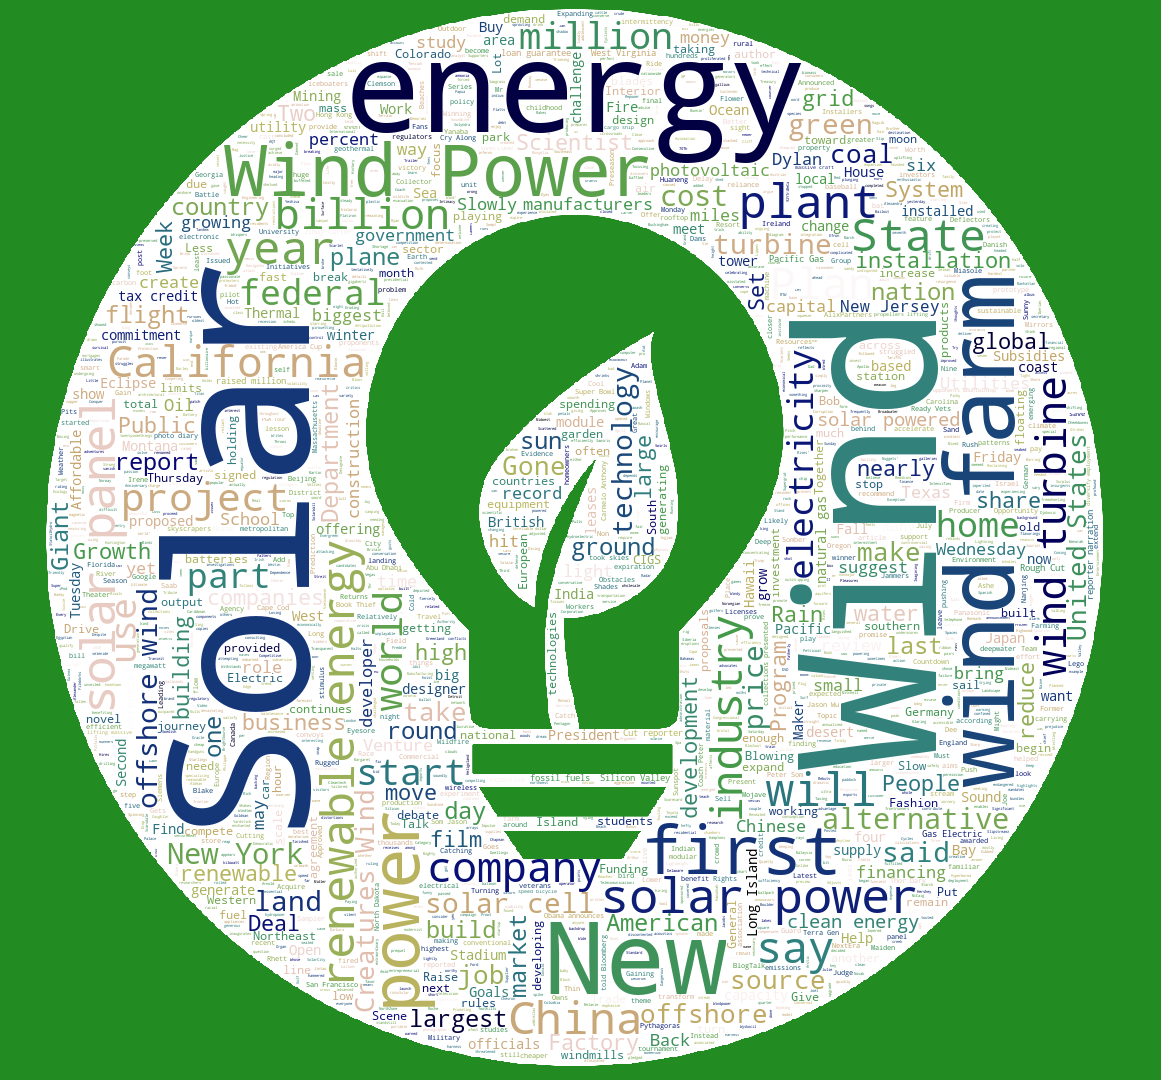

In [26]:
# renewable energy
reader_green = NYTReader(nyt_key)
reader_green.get_search_term(search='headline:("Solar", "Wind", "Renewable")', 
                                begin_date='20010101',
                                article_limit=200,
                                verbose=True)

# get list of text sources
text_list = reader_green.build_list_from_sources(source_list=['headlines','snippets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/Renewable-Energy-Consultants.png', transparency=True)

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/green.png",
               colormap='gist_earth', background='forestgreen')


Got 20 docs, from 1946-10-08T00:00:00Z to 2015-01-01T07:11:58Z


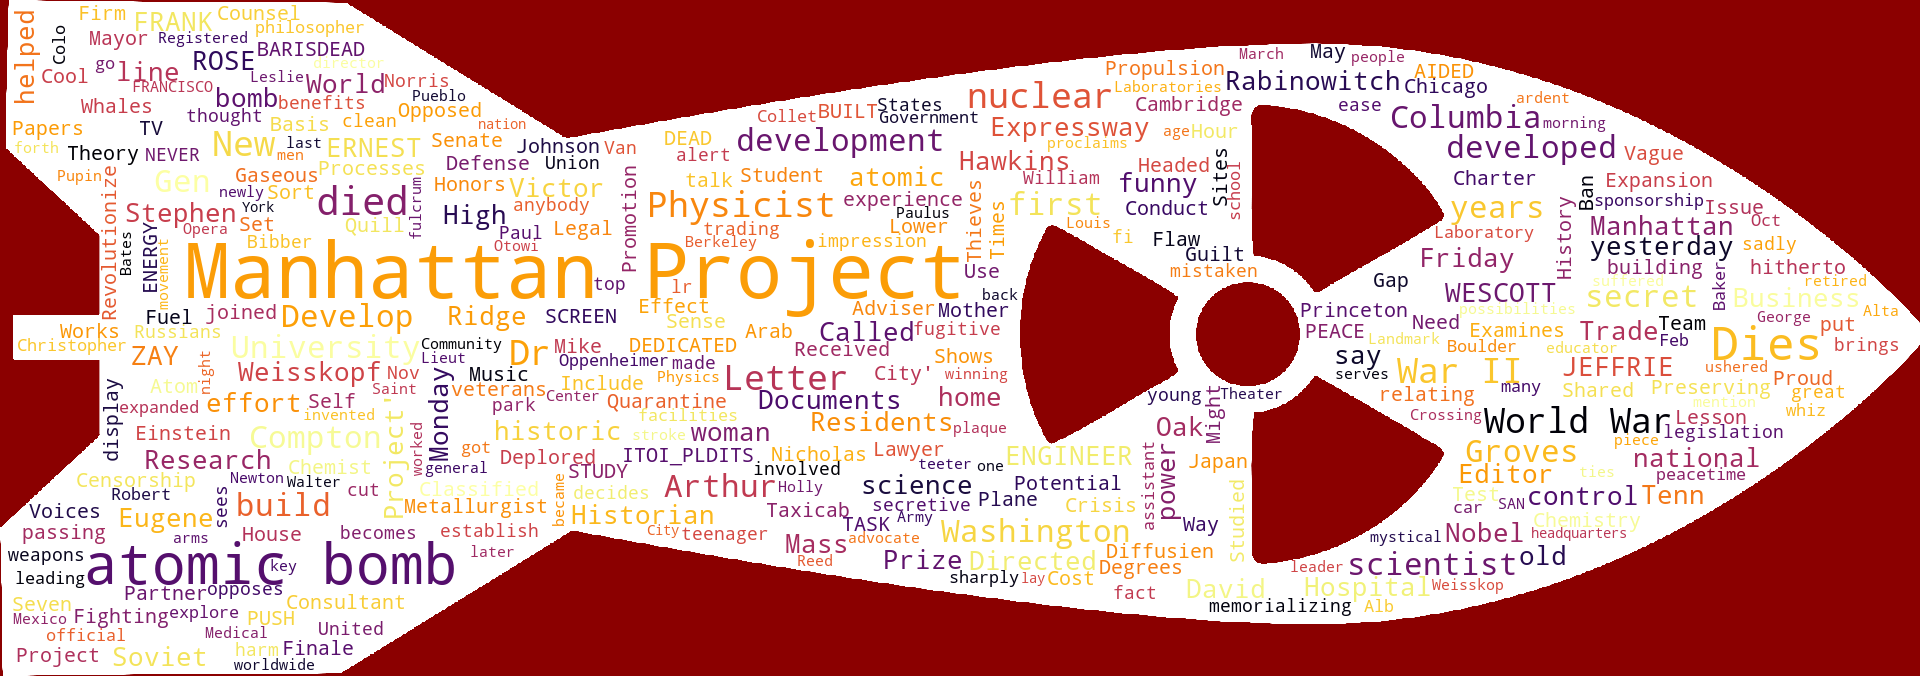

In [27]:
# manhattan project
reader_bomb = NYTReader(nyt_key)
reader_bomb.get_search_term(search='headline:("Manhattan Project")', 
                            article_limit=100,
                            verbose=True)

# get list of text sources
text_list = reader_bomb.build_list_from_sources(source_list=['headlines','snippets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/ABomb.png', transparency=True, rotate=270)

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/bomb.png",
               colormap='inferno', background='darkred')

Got 150 docs, from 1902-11-05T00:00:00Z to 2012-04-09T16:32:56Z


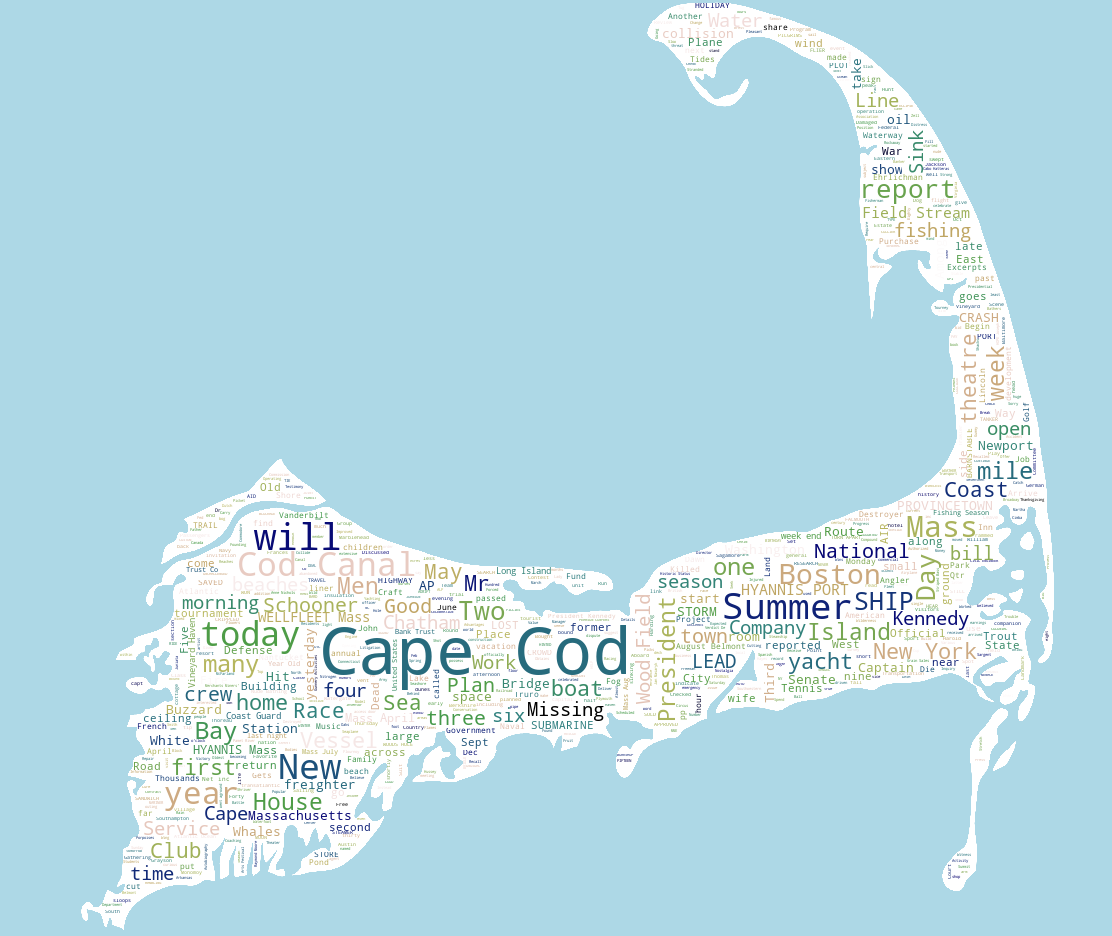

In [28]:
# cape cod
reader_cc = NYTReader(nyt_key)
reader_cc.get_search_term(search='headline:("Cape Cod")', 
                             begin_date='19010101',
                             article_limit=200,
                             verbose=True)

# get list of text sources
text_list = reader_cc.build_list_from_sources(source_list=['headlines','snippets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/capecod.PNG')

wa.make_wordcloud(text=text_list, image=image,
               filename="final images/capecod.png", 
               colormap='gist_earth', background='lightblue')

Got 300 tweets from 2018-05-18 02:51:20 to 2018-05-27 17:10:11, allowance now 162 requests


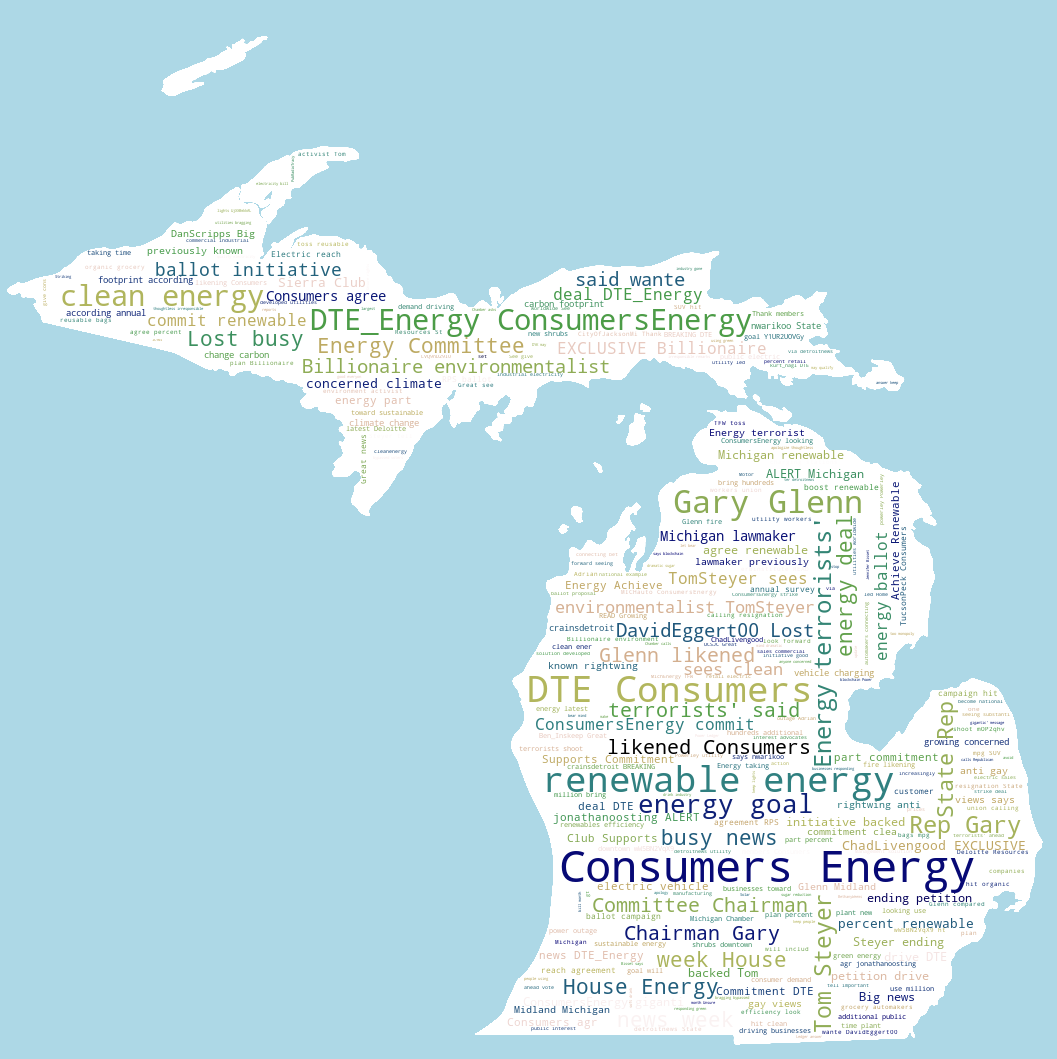

In [29]:
# utilities in mi
reader_mi = TwitterReader(auth)
reader_mi.get_search_term(search=['Consumers Energy', 'ConsumersEnergy', 'CE', 'DTE'], 
                          geo='43.900689,-84.782134,300mi',
                          tweet_limit=300,
                          verbose=True)

# get list of text sources
text_list = reader_mi.build_list_from_sources(source_list=['tweets'])

# make image and wordcloud
wa= WordArt()
image = wa.create_mask_image('source images/Michigan.PNG')

wa.make_wordcloud(text=text_list, image=image,
                  filename="final images/utilities.png",
                  colormap='gist_earth', background='lightblue',
                  additional_stopwords=['https', 'co', 'amp', 'RT'])


# Help and introspection

## NYTReader

In [30]:
help(reader_sf)
print('Data: %s' % ', '.join([key for key in reader_sf.__dict__.keys()]))

Help on NYTReader in module __main__ object:

class NYTReader(WordsAPI)
 |  Reads NYT article API
 |  
 |  Method resolution order:
 |      NYTReader
 |      WordsAPI
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, key=None)
 |  
 |  get_search_term(self, search=None, article_limit=50, begin_date=None, end_date=None, verbose=False)
 |      Fetches results for a search string and/or a date range of string format YYYMMDD
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from WordsAPI:
 |  
 |  build_list_from_sources(self, source_list)
 |      strings together all entities from source list
 |  
 |  df_from_text(self, source_list)
 |      Creates df from a text source
 |  
 |  get_single_entity(self, i)
 |      Prints a representation of the complete ith source
 |  
 |  get_words(self, source_list, pos_list=None, exclude=False)
 |      Returns filtered list of words from df
 |  
 |  plot_top_words(self, df,

## TwitterReader

In [31]:
help(reader_twitter)
print('Data: %s' % ', '.join([key for key in reader_twitter.__dict__.keys()]))

Help on TwitterReader in module __main__ object:

class TwitterReader(WordsAPI)
 |  Reads NYT article API
 |  
 |  Method resolution order:
 |      TwitterReader
 |      WordsAPI
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __init__(self, auth=None)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  get_recent_tweets(self, tweet_limit=200, location_box=None, verbose=False)
 |      Fetches recent tweets, with optional location defined as LON,LAT,LON,LAT 
 |      with SW corner coming first
 |  
 |  get_search_term(self, search='', tweet_limit=200, geo=None, verbose=False, recent=False)
 |      Fetches results for a search string and optional geocode
 |      of string format LAT,LON,RADIUSmi
 |  
 |  ----------------------------------------------------------------------
 |  Methods inherited from WordsAPI:
 |  
 |  build_list_from_sources(self, source_list)
 |      strings together all entities from source list
 |  
 |  df_from_text(self, s

## WordArt

In [32]:
help(wa)

Help on WordArt in module __main__ object:

class WordArt(builtins.object)
 |  Class for creating word art images
 |  
 |  Methods defined here:
 |  
 |  create_mask_image(self, image_location, invert=False, rotate=0, transparency=False, max_size=None)
 |      Creates a proper image with white areas for masking
 |  
 |  make_wordcloud(self, text, filename, image=None, colormap='viridis', background='white', max_words=4000, additional_stopwords=None, desktop=False, max_size=(1920, 1080), reset_stopwords=False)
 |  
 |  ----------------------------------------------------------------------
 |  Data descriptors defined here:
 |  
 |  __dict__
 |      dictionary for instance variables (if defined)
 |  
 |  __weakref__
 |      list of weak references to the object (if defined)

